In [9]:
import random
from pathlib import Path
import time
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import nibabel as nib
from torch.utils.data import DataLoader
from tqdm import tqdm

from decoder_pretrain import DecoderPretrainNet
from encoder_pretrain import EncoderPretrainNet
from gloss_dminus import GlobalLossDminus
from seg_unet import UNet
import torch.nn.functional as F
from training_utils import double_std, plot_losses

import json
import statistics
from sklearn.metrics import f1_score
import pickle

import scipy.stats as sp

In [10]:
def plot_losses(save_directory):
    
    save_models = save_directory + '/save_models/'
    infile = open(save_directory + '/losses.pkl','rb')
    losses = pickle.load(infile)
    
    losses_min = losses.loc[losses['validation loss'] == losses['validation loss'].min()]

    plt.figure()
    losses[100:].plot(x = 'epoch', y =['train loss','validation loss'],mark_right=False)
    plt.savefig(save_directory + '/loss.png')

    plt.figure()

In [11]:
def plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file, plot_loss = False, last_epoch = False) :
    results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        if last_epoch and pretraining != 'baseline':
                            save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val_pretrainedEpoch1499/run_' + str(run)
                        else : 
                            save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        if plot_loss :
                            plot_losses(save_directory_name)
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        
                        results_BN['batch_size'] = batch_size
                        results = results.append(results_BN)
    results['model'].loc[results['model'] == 'pretrained with 4 datasets (representation_loss_global_dminus_2tf)']= 'pretrained with 4 datasets (representation_loss_global_dminus)'
    results['model'].loc[results['model'] == 'pretrained with 4 datasets (representation_loss)']= 'pretrained with 4 datasets (representation_loss_global_d)'
    
    results_mean = results.groupby([ "n vol train", "batch_size", "loss unet", "model"]).agg([np.mean, double_std, sp.sem])
    #print(results_mean)
    results_test_f1 = results_mean['test F1']
    results_test_f1.unstack().plot(kind = "bar", y = "mean",  title = "results_test_f1 ", yerr = "sem").get_figure()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig('trained_models/Cardiac_only/figures/'+ save_file +'.png', bbox_inches='tight')
    return results_test_f1, results


In [12]:
import seaborn as sns
def boxplot(ave_directory, lr, pretrainings, n_trains, batch_sizes, losses, save_file, plot_loss = False) :
    results = pd.DataFrame(columns = ['model', 'n vol train', 'lr', 'wgt_pretrain', 'train F1', 'validation F1', 'test F1', 
                                  'train loss', 'validation loss', 'best epoch'])
    for loss in losses :
        for n_train in n_trains :
            for pretraining in pretrainings :
                for batch_size in batch_sizes :
                    for run in runs :
                        save_directory_name = save_directory + pretraining + '/batch_size_' + str(batch_size) + '/'+ loss+ '_lr_' + str(lr) + '_' + str(n_train) + \
                                                 '_vol_in_train_2_vol_in_val/run_' + str(run)
                        if plot_loss :
                            plot_losses(save_directory_name)
                        infile = open(save_directory_name + '/results.pkl','rb')
                        results_BN = pickle.load(infile)
                        
                        results_BN['batch_size'] = batch_size
                        results = results.append(results_BN)
                        
    #results_mean = results.groupby([ "n vol train", "batch_size", "model"])
    sns.boxplot(x= results["n vol train"], y = results['test F1'], hue = results["model"], palette = 'husl')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    

# Results ACDC

### Batch size comparaison

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           16.0       crossentropy_loss baseline                                            0.537645   
                                         pretrained with 4 datasets (2 steps global_d)       0.525420   
                                         pretrained with 4 datasets (global_d)               0.550824   
                                         pretrained with 4 datasets (global_dminus)          0.562817   
                                         pretrained with 4 datasets (representation_loss...  0.568164   
                                         pretrained with 4 datasets (representation_loss...  0.592198   
                                         pretrained with ACDC FullTrainSet (global_d)        0.614007   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.611080   
                                         pretrained with ACDC FullTrainSet (representati...  0.563315   
                                         pretrained with ACDC FullTrainSet (representati...  0.569382   
2           16.0       crossentropy_loss baseline                                            0.607555   
                                         pretrained with 4 datasets (2 steps global_d)       0.640024   
                                         pretrained with 4 datasets (global_d)               0.633553   
                                         pretrained with 4 datasets (global_dminus)          0.690673   
                                         pretrained with 4 datasets (representation_loss...  0.655595   
                                         pretrained with 4 datasets (representation_loss...  0.661115   
                                         pretrained with ACDC FullTrainSet (global_d)        0.685753   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.690500   
                                         pretrained with ACDC FullTrainSet (representati...  0.685431   
                                         pretrained with ACDC FullTrainSet (representati...  0.651559   
5           16.0       crossentropy_loss baseline                                            0.766953   
                                         pretrained with 4 datasets (2 steps global_d)       0.797809   
                                         pretrained with 4 datasets (global_d)               0.784999   
                                         pretrained with 4 datasets (global_dminus)          0.792196   
                                         pretrained with 4 datasets (representation_loss...  0.793189   
                                         pretrained with 4 datasets (representation_loss...  0.790606   
                                         pretrained with ACDC FullTrainSet (global_d)        0.817401   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.818331   
                                         pretrained with ACDC FullTrainSet (representati...  0.809154   
                                         pretrained with ACDC FullTrainSet (representati...  0.788507   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           16.0       crossentropy_loss baseline                                              0.246149   
                                         pretrained with 4 datasets (2 steps global_d)         0.193984   
                                         pretrained with 4 datasets (global_d)                 0.186574   
                                         pretrained with 4 datasets (global_dminus)            0.220888   
                                         pretrained with 4 datasets (representation_loss...   

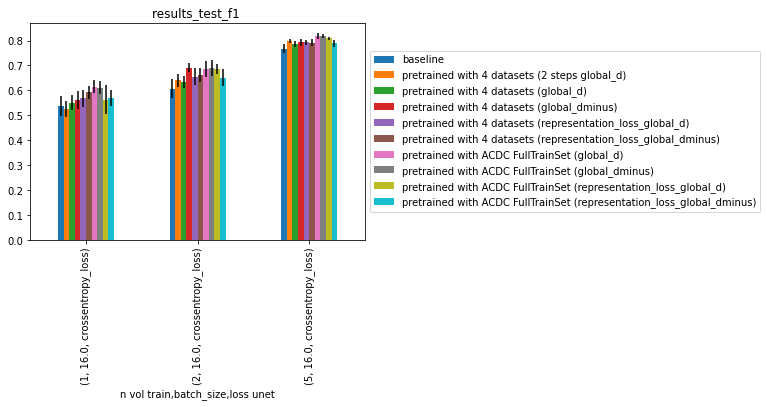

In [74]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']

pretrainings = ['baseline',
                'pretrained with 4 datasets (2 steps global_d)',
                #'pretrained with 4 datasets (2 steps global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
                
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with ACDC FullTrainSet (representation_loss_global_d)',
                'pretrained with ACDC FullTrainSet (representation_loss_global_dminus)',
                
               ]
n_trains = [1, 2, 5]#, 8]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes  = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

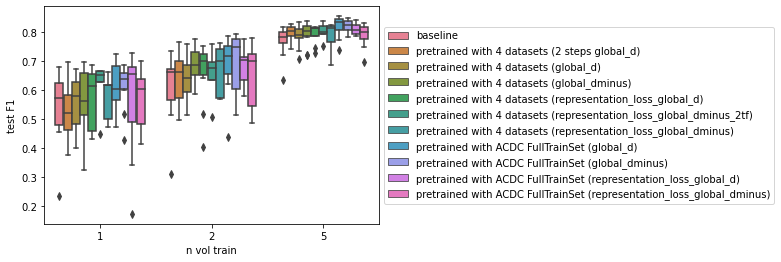

In [75]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

### Global Dminus (Only a transformation is positive examples)

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                         
1           16.0       crossentropy_loss baseline                                           0.537645   
                                         pretrained with 4 datasets (global_dminus)         0.562817   
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.611080   
2           16.0       crossentropy_loss baseline                                           0.607555   
                                         pretrained with 4 datasets (global_dminus)         0.690673   
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.690500   
5           16.0       crossentropy_loss baseline                                           0.766953   
                                         pretrained with 4 datasets (global_dminus)         0.792196   
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.818331   
8           16.0       crossentropy_loss baseline                                           0.830891   
                                         pretrained with 4 datasets (global_dminus)         0.836238   
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.840626   

                                                                                            double_std  \
n vol train batch_size loss unet         model                                                           
1           16.0       crossentropy_loss baseline                                             0.246149   
                                         pretrained with 4 datasets (global_dminus)           0.220888   
                                         pretrained with ACDC FullTrainSet (global_dminus)    0.155280   
2           16.0       crossentropy_loss baseline                                             0.237397   
                                         pretrained with 4 datasets (global_dminus)           0.112143   
                                         pretrained with ACDC FullTrainSet (global_dminus)    0.200766   
5           16.0       crossentropy_loss baseline                                             0.102982   
                                         pretrained with 4 datasets (global_dminus)           0.077008   
                                         pretrained with ACDC FullTrainSet (global_dminus)    0.042135   
8           16.0       crossentropy_loss baseline                                             0.028487   
                                         pretrained with 4 datasets (global_dminus)           0.023827   
                                         pretrained with ACDC FullTrainSet (global_dminus)    0.029022   

                                                                                                 sem  
n vol train batch_size loss unet         model                                                        
1           16.0       crossentropy_loss baseline                                           0.041025  
                                         pretrained with 4 datasets (global_dminus)         0.036815  
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.025880  
2           16.0       crossentropy_loss baseline                                           0.039566  
                                         pretrained with 4 datasets (global_dminus)         0.018691  
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.033461  
5           16.0       crossentropy_loss baseline                                           0.017164  
                                         pretrained with 4 datasets (global_dminus)         0.012835  
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.007022  
8           16.0     

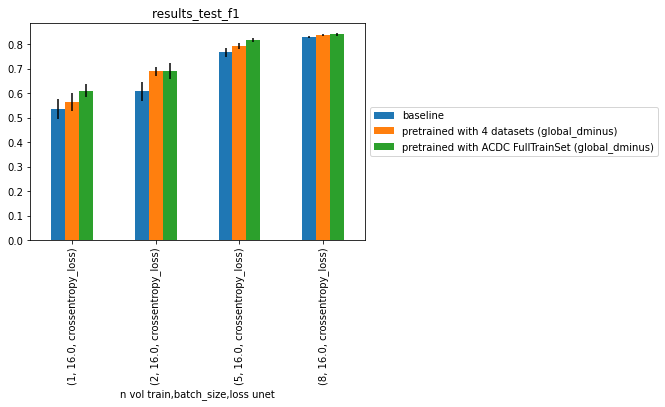

In [17]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with 4 datasets (global_dminus)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

### Global D (Include same partition as positive examples)

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                    
1           16.0       crossentropy_loss baseline                                      0.537645   
                                         pretrained with 4 datasets (global_d)         0.550824   
                                         pretrained with ACDC FullTrainSet (global_d)  0.614007   
2           16.0       crossentropy_loss baseline                                      0.607555   
                                         pretrained with 4 datasets (global_d)         0.633553   
                                         pretrained with ACDC FullTrainSet (global_d)  0.685753   
5           16.0       crossentropy_loss baseline                                      0.766953   
                                         pretrained with 4 datasets (global_d)         0.784999   
                                         pretrained with ACDC FullTrainSet (global_d)  0.817401   
8           16.0       crossentropy_loss baseline                                      0.830891   
                                         pretrained with 4 datasets (global_d)         0.837739   
                                         pretrained with ACDC FullTrainSet (global_d)  0.840535   

                                                                                       double_std  \
n vol train batch_size loss unet         model                                                      
1           16.0       crossentropy_loss baseline                                        0.246149   
                                         pretrained with 4 datasets (global_d)           0.186574   
                                         pretrained with ACDC FullTrainSet (global_d)    0.155339   
2           16.0       crossentropy_loss baseline                                        0.237397   
                                         pretrained with 4 datasets (global_d)           0.144611   
                                         pretrained with ACDC FullTrainSet (global_d)    0.194993   
5           16.0       crossentropy_loss baseline                                        0.102982   
                                         pretrained with 4 datasets (global_d)           0.076131   
                                         pretrained with ACDC FullTrainSet (global_d)    0.071756   
8           16.0       crossentropy_loss baseline                                        0.028487   
                                         pretrained with 4 datasets (global_d)           0.030852   
                                         pretrained with ACDC FullTrainSet (global_d)    0.037622   

                                                                                            sem  
n vol train batch_size loss unet         model                                                   
1           16.0       crossentropy_loss baseline                                      0.041025  
                                         pretrained with 4 datasets (global_d)         0.031096  
                                         pretrained with ACDC FullTrainSet (global_d)  0.025890  
2           16.0       crossentropy_loss baseline                                      0.039566  
                                         pretrained with 4 datasets (global_d)         0.024102  
                                         pretrained with ACDC FullTrainSet (global_d)  0.032499  
5           16.0       crossentropy_loss baseline                                      0.017164  
                                         pretrained with 4 datasets (global_d)         0.012688  
                                         pretrained with ACDC FullTrainSet (global_d)  0.011959  
8           16.0       crossentropy_loss baseline                                      0.004748  
                                         pretrained with 4 datasets (global_d)         0.005142  
               

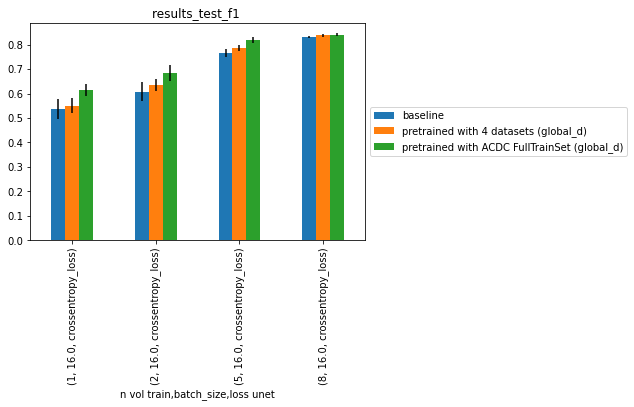

In [19]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (global_d)',
                'pretrained with ACDC FullTrainSet (global_d)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains,batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

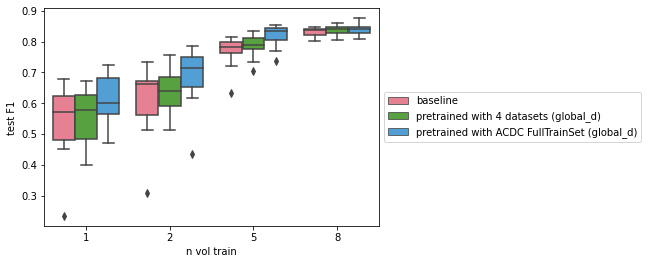

In [20]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

## ACDC pretraining VS 4 datasets pretraining (ACDC, HCP, Chaos and MedDecat Prostate)

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           16.0       crossentropy_loss baseline                                            0.537645   
                                         pretrained with 4 datasets (global_d)               0.550824   
                                         pretrained with 4 datasets (global_dminus)          0.562817   
                                         pretrained with 4 datasets (representation_loss...  0.568164   
                                         pretrained with 4 datasets (representation_loss...  0.592198   
                                         pretrained with ACDC FullTrainSet (global_d)        0.614007   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.611080   
                                         pretrained with ACDC FullTrainSet (representati...  0.563315   
                                         pretrained with ACDC FullTrainSet (representati...  0.569382   
2           16.0       crossentropy_loss baseline                                            0.607555   
                                         pretrained with 4 datasets (global_d)               0.633553   
                                         pretrained with 4 datasets (global_dminus)          0.690673   
                                         pretrained with 4 datasets (representation_loss...  0.655595   
                                         pretrained with 4 datasets (representation_loss...  0.661115   
                                         pretrained with ACDC FullTrainSet (global_d)        0.685753   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.690500   
                                         pretrained with ACDC FullTrainSet (representati...  0.685431   
                                         pretrained with ACDC FullTrainSet (representati...  0.651559   
5           16.0       crossentropy_loss baseline                                            0.766953   
                                         pretrained with 4 datasets (global_d)               0.784999   
                                         pretrained with 4 datasets (global_dminus)          0.792196   
                                         pretrained with 4 datasets (representation_loss...  0.793189   
                                         pretrained with 4 datasets (representation_loss...  0.790606   
                                         pretrained with ACDC FullTrainSet (global_d)        0.817401   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.818331   
                                         pretrained with ACDC FullTrainSet (representati...  0.809154   
                                         pretrained with ACDC FullTrainSet (representati...  0.788507   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           16.0       crossentropy_loss baseline                                              0.246149   
                                         pretrained with 4 datasets (global_d)                 0.186574   
                                         pretrained with 4 datasets (global_dminus)            0.220888   
                                         pretrained with 4 datasets (representation_loss...    0.196507   
                                         pretrained with 4 datasets (representation_loss...    0.162223   
                                         pretrained with ACDC FullTrainSet (global_d)          0.155339   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.155280   
                                         pretrained with ACDC FullTrainSet (representati

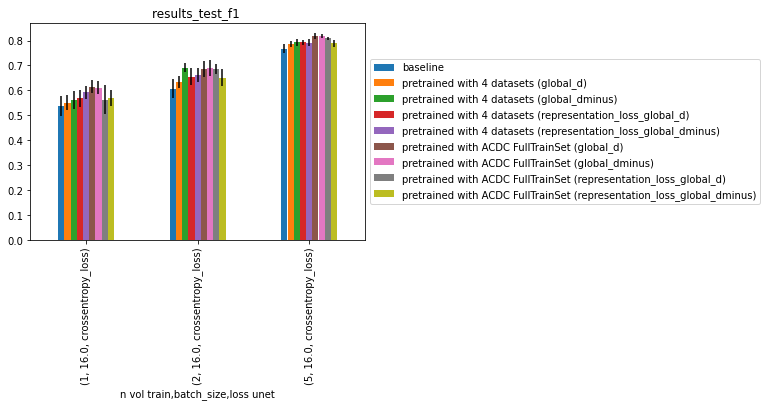

In [32]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with ACDC FullTrainSet (representation_loss_global_d)',
                'pretrained with ACDC FullTrainSet (representation_loss_global_dminus)',
                
                #'pretrained with 4 datasets (2 steps global_d)',
                #'pretrained with 4 datasets (2 steps global_dminus)',
                
               ]
n_trains = [1, 2, 5]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

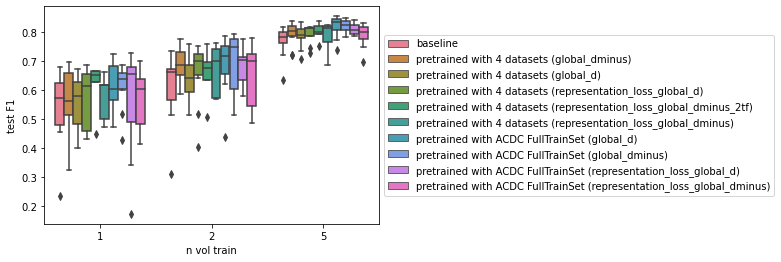

In [33]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

## Global D VS Global Dminus

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                         
1           16.0       crossentropy_loss baseline                                           0.537645   
                                         pretrained with 4 datasets (global_d)              0.550824   
                                         pretrained with 4 datasets (global_dminus)         0.562817   
                                         pretrained with ACDC FullTrainSet (global_d)       0.614007   
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.611080   
2           16.0       crossentropy_loss baseline                                           0.607555   
                                         pretrained with 4 datasets (global_d)              0.633553   
                                         pretrained with 4 datasets (global_dminus)         0.690673   
                                         pretrained with ACDC FullTrainSet (global_d)       0.685753   
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.690500   
5           16.0       crossentropy_loss baseline                                           0.766953   
                                         pretrained with 4 datasets (global_d)              0.784999   
                                         pretrained with 4 datasets (global_dminus)         0.792196   
                                         pretrained with ACDC FullTrainSet (global_d)       0.817401   
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.818331   
8           16.0       crossentropy_loss baseline                                           0.830891   
                                         pretrained with 4 datasets (global_d)              0.837739   
                                         pretrained with 4 datasets (global_dminus)         0.836238   
                                         pretrained with ACDC FullTrainSet (global_d)       0.840535   
                                         pretrained with ACDC FullTrainSet (global_dminus)  0.840626   

                                                                                            double_std  \
n vol train batch_size loss unet         model                                                           
1           16.0       crossentropy_loss baseline                                             0.246149   
                                         pretrained with 4 datasets (global_d)                0.186574   
                                         pretrained with 4 datasets (global_dminus)           0.220888   
                                         pretrained with ACDC FullTrainSet (global_d)         0.155339   
                                         pretrained with ACDC FullTrainSet (global_dminus)    0.155280   
2           16.0       crossentropy_loss baseline                                             0.237397   
                                         pretrained with 4 datasets (global_d)                0.144611   
                                         pretrained with 4 datasets (global_dminus)           0.112143   
                                         pretrained with ACDC FullTrainSet (global_d)         0.194993   
                                         pretrained with ACDC FullTrainSet (global_dminus)    0.200766   
5           16.0       crossentropy_loss baseline                                             0.102982   
                                         pretrained with 4 datasets (global_d)                0.076131   
                                         pretrained with 4 datasets (global_dminus)           0.077008   
                                         pretrained with ACDC FullTrainSet (global_d)         0.071756   
                                         pretrained with ACDC FullTrainSet (global_dminus)    0.042135   
8    

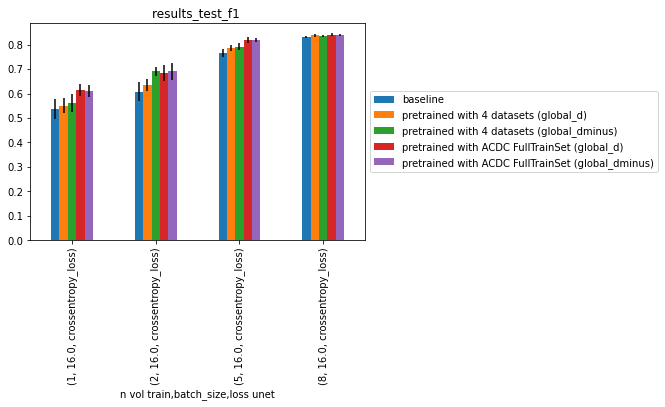

In [36]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

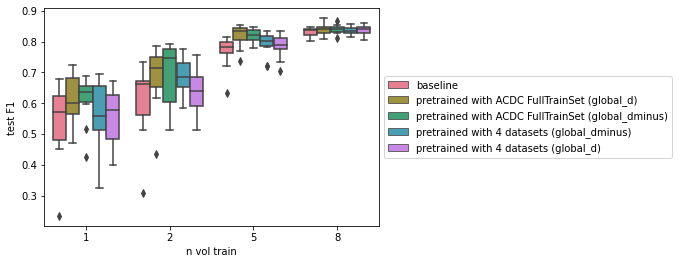

In [37]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

### Global Dminus 1 VS 4 datasets 

### Global D 1 VS 4 datasets 

### 2 steps Global D : compute loss contrasting between dataset + within each dataset, between partitions

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                     
1           16.0       crossentropy_loss baseline                                       0.537645   
                                         pretrained with 4 datasets (2 steps global_d)  0.525420   
                                         pretrained with 4 datasets (global_d)          0.550824   
                                         pretrained with ACDC FullTrainSet (global_d)   0.614007   
2           16.0       crossentropy_loss baseline                                       0.607555   
                                         pretrained with 4 datasets (2 steps global_d)  0.640024   
                                         pretrained with 4 datasets (global_d)          0.633553   
                                         pretrained with ACDC FullTrainSet (global_d)   0.685753   
5           16.0       crossentropy_loss baseline                                       0.766953   
                                         pretrained with 4 datasets (2 steps global_d)  0.797809   
                                         pretrained with 4 datasets (global_d)          0.784999   
                                         pretrained with ACDC FullTrainSet (global_d)   0.817401   
8           16.0       crossentropy_loss baseline                                       0.830891   
                                         pretrained with 4 datasets (2 steps global_d)  0.834299   
                                         pretrained with 4 datasets (global_d)          0.837739   
                                         pretrained with ACDC FullTrainSet (global_d)   0.840535   

                                                                                        double_std  \
n vol train batch_size loss unet         model                                                       
1           16.0       crossentropy_loss baseline                                         0.246149   
                                         pretrained with 4 datasets (2 steps global_d)    0.193984   
                                         pretrained with 4 datasets (global_d)            0.186574   
                                         pretrained with ACDC FullTrainSet (global_d)     0.155339   
2           16.0       crossentropy_loss baseline                                         0.237397   
                                         pretrained with 4 datasets (2 steps global_d)    0.165343   
                                         pretrained with 4 datasets (global_d)            0.144611   
                                         pretrained with ACDC FullTrainSet (global_d)     0.194993   
5           16.0       crossentropy_loss baseline                                         0.102982   
                                         pretrained with 4 datasets (2 steps global_d)    0.048475   
                                         pretrained with 4 datasets (global_d)            0.076131   
                                         pretrained with ACDC FullTrainSet (global_d)     0.071756   
8           16.0       crossentropy_loss baseline                                         0.028487   
                                         pretrained with 4 datasets (2 steps global_d)    0.024929   
                                         pretrained with 4 datasets (global_d)            0.030852   
                                         pretrained with ACDC FullTrainSet (global_d)     0.037622   

                                                                                             sem  
n vol train batch_size loss unet         model                                                    
1           16.0       crossentropy_loss baseline                                       0.041025  
                                         pretrained with 4 datasets (2 steps global_d)  0.032331  
                                         pretrained with 4

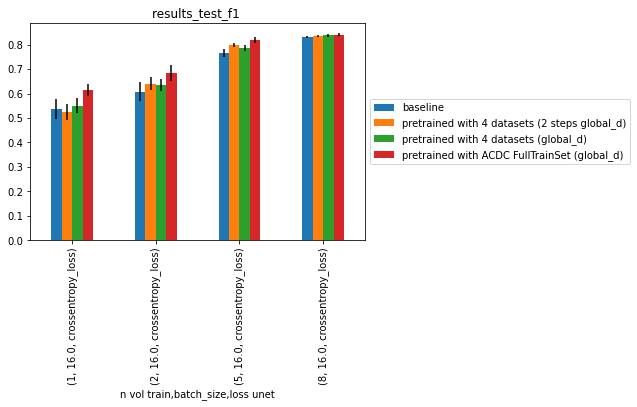

In [51]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with ACDC FullTrainSet (global_d)',
                
               ]
n_trains = [1, 2, 5, 8]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

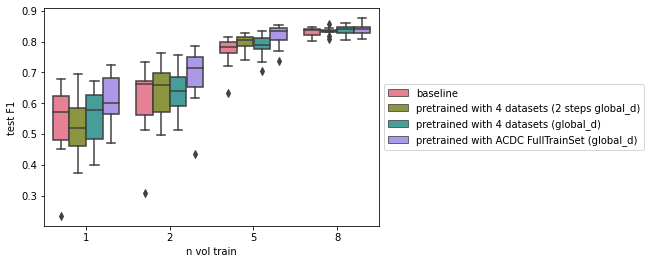

In [52]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

## 2 steps global dminus

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           16.0       crossentropy_loss baseline                                            0.577474   
                                         pretrained with 4 datasets (2 steps global_dminus)  0.547881   
                                         pretrained with 4 datasets (global_dminus)          0.547833   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.622440   
2           16.0       crossentropy_loss baseline                                            0.617986   
                                         pretrained with 4 datasets (2 steps global_dminus)  0.626576   
                                         pretrained with 4 datasets (global_dminus)          0.687605   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.705921   
5           16.0       crossentropy_loss baseline                                            0.772359   
                                         pretrained with 4 datasets (2 steps global_dminus)  0.774173   
                                         pretrained with 4 datasets (global_dminus)          0.793377   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.824466   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           16.0       crossentropy_loss baseline                                              0.157258   
                                         pretrained with 4 datasets (2 steps global_dminus)    0.202396   
                                         pretrained with 4 datasets (global_dminus)            0.238834   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.121430   
2           16.0       crossentropy_loss baseline                                              0.148219   
                                         pretrained with 4 datasets (2 steps global_dminus)    0.172110   
                                         pretrained with 4 datasets (global_dminus)            0.067891   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.159216   
5           16.0       crossentropy_loss baseline                                              0.061121   
                                         pretrained with 4 datasets (2 steps global_dminus)    0.064901   
                                         pretrained with 4 datasets (global_dminus)            0.081231   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.030088   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           16.0       crossentropy_loss baseline                                            0.039315  
                                         pretrained with 4 datasets (2 steps global_dminus)  0.050599  
                                         pretrained with 4 datasets (global_dminus)          0.059709  
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.030358  
2           16.0       crossentropy_loss baseline                                            0.037055  
                                         pretrained with 4 datasets (2 steps global_dminus)  0.043028  
                                         pretrained with 4 datasets (global_dminus)          0.016973  
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.039804  
5           16.0       crossentropy_loss baseline                                      

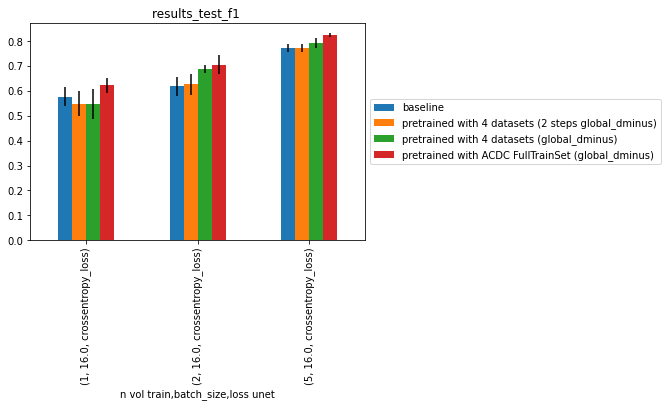

In [49]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4']#, '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (2 steps global_dminus)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with ACDC FullTrainSet (global_dminus)',
                
               ]
n_trains = [1, 2,5]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

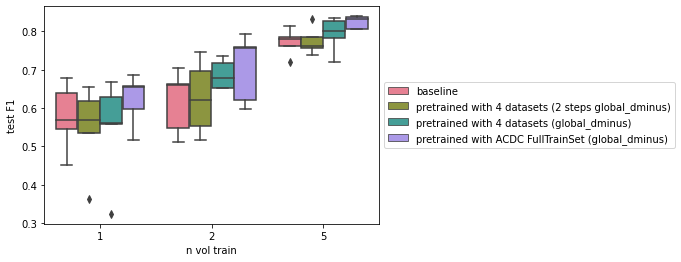

In [50]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

#### Representation loss : Compute loss one layer before the last dense layer and add it to the regular global d loss

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           16.0       crossentropy_loss baseline                                            0.537645   
                                         pretrained with 4 datasets (global_d)               0.550824   
                                         pretrained with 4 datasets (representation_loss...  0.568164   
                                         pretrained with ACDC FullTrainSet (global_d)        0.614007   
                                         pretrained with ACDC FullTrainSet (representati...  0.563315   
2           16.0       crossentropy_loss baseline                                            0.607555   
                                         pretrained with 4 datasets (global_d)               0.633553   
                                         pretrained with 4 datasets (representation_loss...  0.655595   
                                         pretrained with ACDC FullTrainSet (global_d)        0.685753   
                                         pretrained with ACDC FullTrainSet (representati...  0.685431   
5           16.0       crossentropy_loss baseline                                            0.766953   
                                         pretrained with 4 datasets (global_d)               0.784999   
                                         pretrained with 4 datasets (representation_loss...  0.793189   
                                         pretrained with ACDC FullTrainSet (global_d)        0.817401   
                                         pretrained with ACDC FullTrainSet (representati...  0.809154   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           16.0       crossentropy_loss baseline                                              0.246149   
                                         pretrained with 4 datasets (global_d)                 0.186574   
                                         pretrained with 4 datasets (representation_loss...    0.196507   
                                         pretrained with ACDC FullTrainSet (global_d)          0.155339   
                                         pretrained with ACDC FullTrainSet (representati...    0.349102   
2           16.0       crossentropy_loss baseline                                              0.237397   
                                         pretrained with 4 datasets (global_d)                 0.144611   
                                         pretrained with 4 datasets (representation_loss...    0.210816   
                                         pretrained with ACDC FullTrainSet (global_d)          0.194993   
                                         pretrained with ACDC FullTrainSet (representati...    0.127006   
5           16.0       crossentropy_loss baseline                                              0.102982   
                                         pretrained with 4 datasets (global_d)                 0.076131   
                                         pretrained with 4 datasets (representation_loss...    0.062195   
                                         pretrained with ACDC FullTrainSet (global_d)          0.071756   
                                         pretrained with ACDC FullTrainSet (representati...    0.035131   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           16.0       crossentropy_loss baseline                                            0.041025  
                                         pretrained with 4 datasets (global_d)               0.031096  
                                         pretrained with 4 datasets (repres

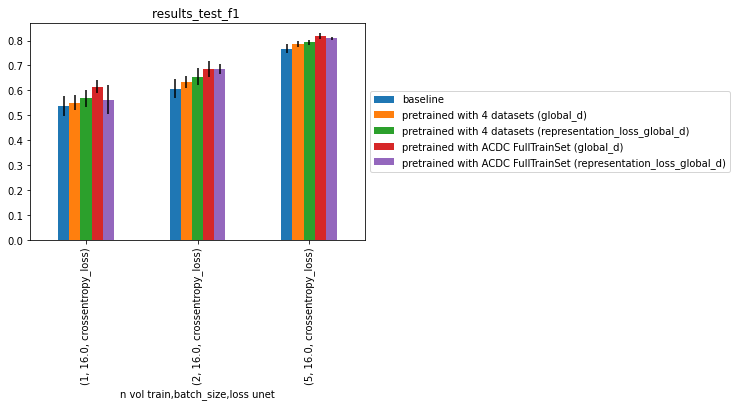

In [45]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (representation_loss_global_d)',
               ]
n_trains = [1, 2, 5]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains,batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

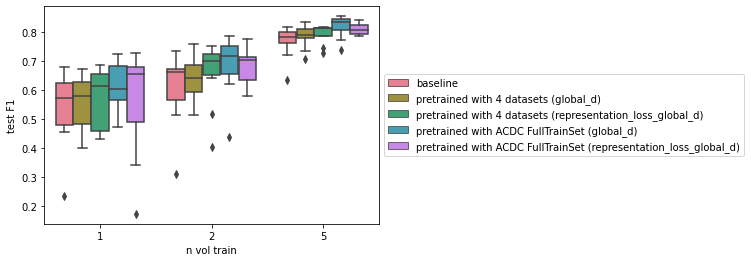

In [46]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

## Representation loss global dminus

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           16.0       crossentropy_loss baseline                                            0.577474   
                                         pretrained with 4 datasets (global_dminus)          0.547833   
                                         pretrained with 4 datasets (representation_loss...  0.610612   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.622440   
2           16.0       crossentropy_loss baseline                                            0.617986   
                                         pretrained with 4 datasets (global_dminus)          0.687605   
                                         pretrained with 4 datasets (representation_loss...  0.653571   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.705921   
5           16.0       crossentropy_loss baseline                                            0.772359   
                                         pretrained with 4 datasets (global_dminus)          0.793377   
                                         pretrained with 4 datasets (representation_loss...  0.799468   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.824466   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           16.0       crossentropy_loss baseline                                              0.157258   
                                         pretrained with 4 datasets (global_dminus)            0.238834   
                                         pretrained with 4 datasets (representation_loss...    0.167539   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.121430   
2           16.0       crossentropy_loss baseline                                              0.148219   
                                         pretrained with 4 datasets (global_dminus)            0.067891   
                                         pretrained with 4 datasets (representation_loss...    0.167728   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.159216   
5           16.0       crossentropy_loss baseline                                              0.061121   
                                         pretrained with 4 datasets (global_dminus)            0.081231   
                                         pretrained with 4 datasets (representation_loss...    0.058035   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.030088   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           16.0       crossentropy_loss baseline                                            0.039315  
                                         pretrained with 4 datasets (global_dminus)          0.059709  
                                         pretrained with 4 datasets (representation_loss...  0.041885  
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.030358  
2           16.0       crossentropy_loss baseline                                            0.037055  
                                         pretrained with 4 datasets (global_dminus)          0.016973  
                                         pretrained with 4 datasets (representation_loss...  0.041932  
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.039804  
5           16.0       crossentropy_loss baseline                                      

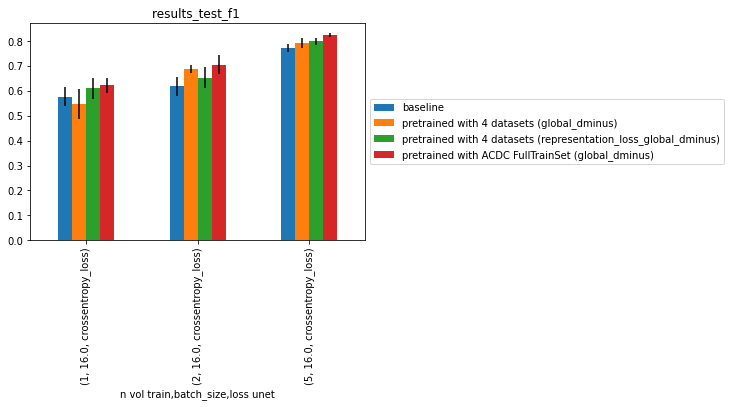

In [47]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4']#, '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
                'pretrained with ACDC FullTrainSet (global_dminus)',
                #'pretrained with ACDC FullTrainSet (representation_loss_global_dminus_2tf)',
                
               ]
n_trains = [1, 2, 5]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains,batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

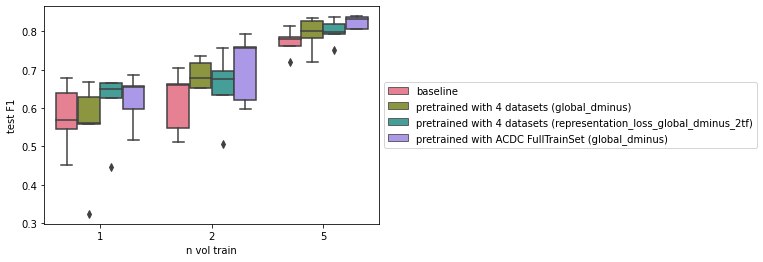

In [48]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

### 4 datasets competition

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           16.0       crossentropy_loss baseline                                            0.537645   
                                         pretrained with 4 datasets (2 steps global_d)       0.525420   
                                         pretrained with 4 datasets (global_d)               0.550824   
                                         pretrained with 4 datasets (global_dminus)          0.562817   
                                         pretrained with 4 datasets (representation_loss...  0.568164   
2           16.0       crossentropy_loss baseline                                            0.607555   
                                         pretrained with 4 datasets (2 steps global_d)       0.640024   
                                         pretrained with 4 datasets (global_d)               0.633553   
                                         pretrained with 4 datasets (global_dminus)          0.690673   
                                         pretrained with 4 datasets (representation_loss...  0.655595   
5           16.0       crossentropy_loss baseline                                            0.766953   
                                         pretrained with 4 datasets (2 steps global_d)       0.797809   
                                         pretrained with 4 datasets (global_d)               0.784999   
                                         pretrained with 4 datasets (global_dminus)          0.792196   
                                         pretrained with 4 datasets (representation_loss...  0.793189   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           16.0       crossentropy_loss baseline                                              0.246149   
                                         pretrained with 4 datasets (2 steps global_d)         0.193984   
                                         pretrained with 4 datasets (global_d)                 0.186574   
                                         pretrained with 4 datasets (global_dminus)            0.220888   
                                         pretrained with 4 datasets (representation_loss...    0.196507   
2           16.0       crossentropy_loss baseline                                              0.237397   
                                         pretrained with 4 datasets (2 steps global_d)         0.165343   
                                         pretrained with 4 datasets (global_d)                 0.144611   
                                         pretrained with 4 datasets (global_dminus)            0.112143   
                                         pretrained with 4 datasets (representation_loss...    0.210816   
5           16.0       crossentropy_loss baseline                                              0.102982   
                                         pretrained with 4 datasets (2 steps global_d)         0.048475   
                                         pretrained with 4 datasets (global_d)                 0.076131   
                                         pretrained with 4 datasets (global_dminus)            0.077008   
                                         pretrained with 4 datasets (representation_loss...    0.062195   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           16.0       crossentropy_loss baseline                                            0.041025  
                                         pretrained with 4 datasets (2 steps global_d)       0.032331  
                                         pretrained with 4 datasets (global

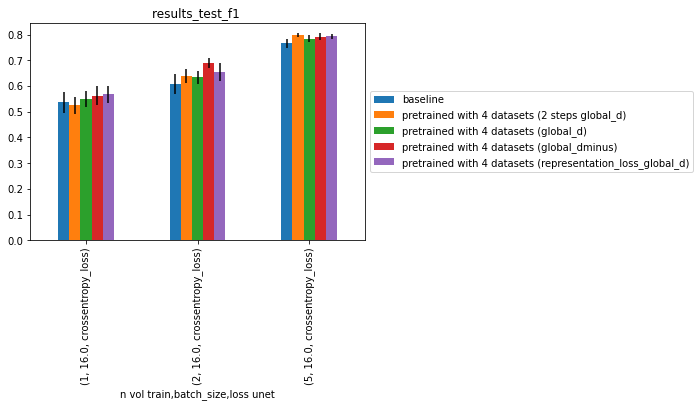

In [56]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (2 steps global_d)',
                
               ]
n_trains = [1, 2, 5]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

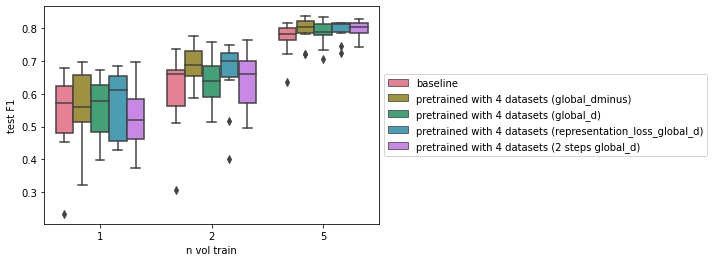

In [57]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

## Demeaned representation loss

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           16.0       crossentropy_loss baseline                                            0.577474   
                                         pretrained with 4 datasets (demeaned_representa...  0.430420   
2           16.0       crossentropy_loss baseline                                            0.617986   
                                         pretrained with 4 datasets (demeaned_representa...  0.508837   
5           16.0       crossentropy_loss baseline                                            0.772359   
                                         pretrained with 4 datasets (demeaned_representa...  0.744565   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           16.0       crossentropy_loss baseline                                              0.157258   
                                         pretrained with 4 datasets (demeaned_representa...    0.244866   
2           16.0       crossentropy_loss baseline                                              0.148219   
                                         pretrained with 4 datasets (demeaned_representa...    0.221137   
5           16.0       crossentropy_loss baseline                                              0.061121   
                                         pretrained with 4 datasets (demeaned_representa...    0.111723   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           16.0       crossentropy_loss baseline                                            0.039315  
                                         pretrained with 4 datasets (demeaned_representa...  0.061217  
2           16.0       crossentropy_loss baseline                                            0.037055  
                                         pretrained with 4 datasets (demeaned_representa...  0.055284  
5           16.0       crossentropy_loss baseline                                            0.015280  
                                         pretrained with 4 datasets (demeaned_representa...  0.027931

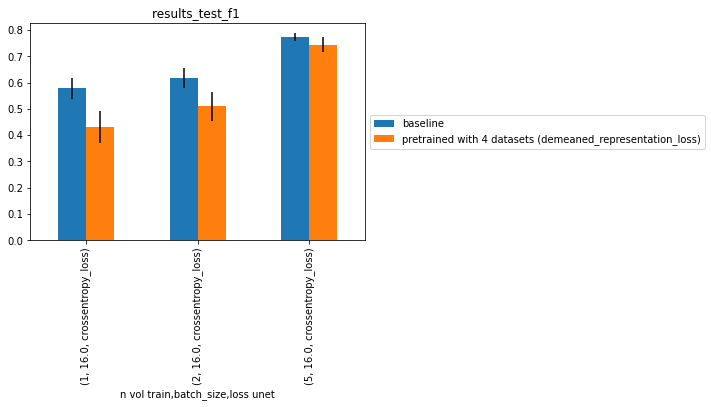

In [58]:
save_directory = './trained_models/Cardiac_only/ACDC/'
runs = ['0','1', '2', '3', '4']
pretrainings = ['baseline', 
                'pretrained with 4 datasets (demeaned_representation_loss)',
               ]
n_trains = [1, 2, 5]
losses = ['crossentropy_loss']
lr = 0.001
batch_sizes = [16]

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,'ACDC_results_f1', plot_loss = False)
results_test_f1

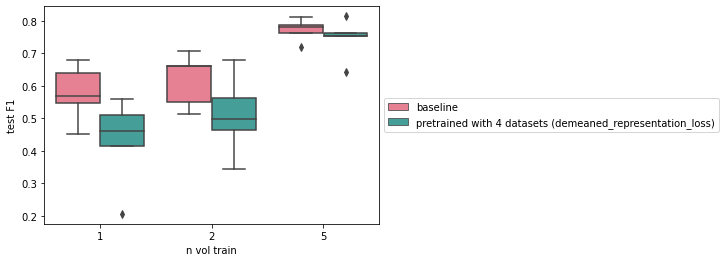

In [59]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

# Results CIMAS,  ACDC pretraining and 4 datasets pretraining

## CIMAS pretrained with ACDC

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           16.0       crossentropy_loss baseline                                            0.516034   
                                         pretrained with ACDC FullTrainSet (global_d)        0.476319   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.498397   
                                         pretrained with ACDC FullTrainSet (representati...  0.441218   
            40.0       crossentropy_loss baseline                                            0.493883   
                                         pretrained with ACDC FullTrainSet (global_d)        0.527198   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.534635   
                                         pretrained with ACDC FullTrainSet (representati...  0.489083   
2           16.0       crossentropy_loss baseline                                            0.499005   
                                         pretrained with ACDC FullTrainSet (global_d)        0.493199   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.498370   
                                         pretrained with ACDC FullTrainSet (representati...  0.459056   
            40.0       crossentropy_loss baseline                                            0.507105   
                                         pretrained with ACDC FullTrainSet (global_d)        0.508014   
                                         pretrained with ACDC FullTrainSet (global_dminus)   0.499247   
                                         pretrained with ACDC FullTrainSet (representati...  0.514539   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           16.0       crossentropy_loss baseline                                              0.076984   
                                         pretrained with ACDC FullTrainSet (global_d)          0.125312   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.107766   
                                         pretrained with ACDC FullTrainSet (representati...    0.445354   
            40.0       crossentropy_loss baseline                                              0.067966   
                                         pretrained with ACDC FullTrainSet (global_d)          0.080596   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.061581   
                                         pretrained with ACDC FullTrainSet (representati...    0.104251   
2           16.0       crossentropy_loss baseline                                              0.165153   
                                         pretrained with ACDC FullTrainSet (global_d)          0.174789   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.133548   
                                         pretrained with ACDC FullTrainSet (representati...    0.181049   
            40.0       crossentropy_loss baseline                                              0.186964   
                                         pretrained with ACDC FullTrainSet (global_d)          0.232186   
                                         pretrained with ACDC FullTrainSet (global_dminus)     0.248739   
                                         pretrained with ACDC FullTrainSet (representati...    0.203482   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           16.0       crossentropy_loss baseline                      

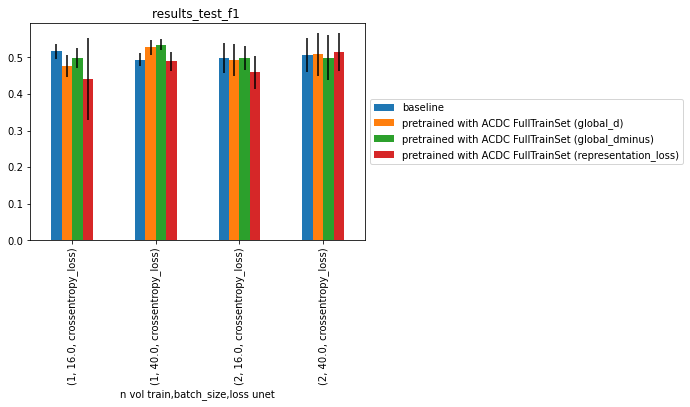

In [60]:
save_directory = './trained_models/Cardiac_only/CIMAS/'
pretrainings = ['baseline', 
                'pretrained with ACDC FullTrainSet (global_d)',
                'pretrained with ACDC FullTrainSet (global_dminus)', 
                'pretrained with ACDC FullTrainSet (representation_loss)',
                #'pretrained with 4 datasets (2 steps global_d)',
                #'pretrained with 4 datasets (global_dminus)',
                #'pretrained with 4 datasets (global_d)',
                #'pretrained with 4 datasets (representation_loss)',
               ]
n_trains = [1, 2]
losses =  ['crossentropy_loss']
lr = 0.001
batch_sizes = [16,40]   
     
runs = [ '0', '1', '2', '3', '4']#, '5', '6', '7', '8', '9']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains,batch_sizes, losses, '/CIMAS_results_f1', plot_loss = False)
results_test_f1

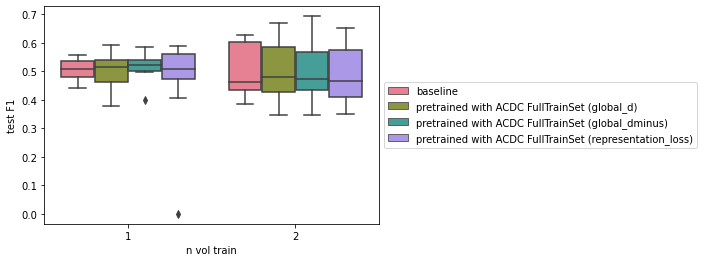

In [61]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

## CIMAS pretrained with 4 datasets

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           40.0       crossentropy_loss baseline                                            0.493883   
                                         pretrained with 4 datasets (2 steps global_d)       0.528017   
                                         pretrained with 4 datasets (global_d)               0.517529   
                                         pretrained with 4 datasets (global_dminus)          0.511093   
                                         pretrained with 4 datasets (representation_loss...  0.520313   
                                         pretrained with 4 datasets (representation_loss...  0.570906   
2           40.0       crossentropy_loss baseline                                            0.507105   
                                         pretrained with 4 datasets (2 steps global_d)       0.498177   
                                         pretrained with 4 datasets (global_d)               0.515950   
                                         pretrained with 4 datasets (global_dminus)          0.505888   
                                         pretrained with 4 datasets (representation_loss...  0.521839   
                                         pretrained with 4 datasets (representation_loss...  0.427553   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           40.0       crossentropy_loss baseline                                              0.067966   
                                         pretrained with 4 datasets (2 steps global_d)         0.068050   
                                         pretrained with 4 datasets (global_d)                 0.071446   
                                         pretrained with 4 datasets (global_dminus)            0.179730   
                                         pretrained with 4 datasets (representation_loss...    0.076149   
                                         pretrained with 4 datasets (representation_loss...    0.079057   
2           40.0       crossentropy_loss baseline                                              0.186964   
                                         pretrained with 4 datasets (2 steps global_d)         0.215812   
                                         pretrained with 4 datasets (global_d)                 0.223027   
                                         pretrained with 4 datasets (global_dminus)            0.223367   
                                         pretrained with 4 datasets (representation_loss...    0.223297   
                                         pretrained with 4 datasets (representation_loss...    0.450617   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           40.0       crossentropy_loss baseline                                            0.016991  
                                         pretrained with 4 datasets (2 steps global_d)       0.017012  
                                         pretrained with 4 datasets (global_d)               0.017862  
                                         pretrained with 4 datasets (global_dminus)          0.044932  
                                         pretrained with 4 datasets (representation_loss...  0.019037  
                                         pretrained with 4 datasets (representation_loss...  0.019764  
2           40.0       crossentropy_loss baseline                                            0.046741  
                                         pretrained with 4 datasets (2 steps global_d)       0.053953  
                                         pretrained with 4 datasets (global_d)         

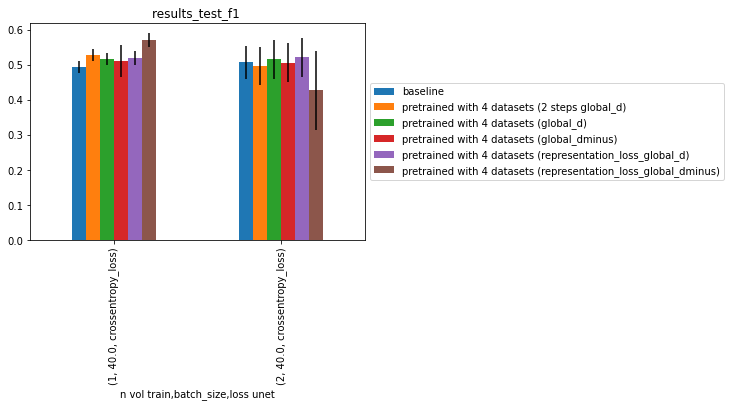

In [62]:
save_directory = './trained_models/Cardiac_only/CIMAS/'
pretrainings = ['baseline', 
                #'pretrained with ACDC FullTrainSet (global_d)',
                #'pretrained with ACDC FullTrainSet (global_dminus)', 
                #'pretrained with ACDC FullTrainSet (representation_loss)',
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
                #'pretrained with 4 datasets (demeaned_representation_loss)'
               ]
n_trains = [1, 2]
losses =  ['crossentropy_loss']
lr = 0.001
batch_sizes = [ 40]   
     
runs = [ '0', '1', '2', '3', '4']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains,batch_sizes, losses, '/CIMAS_results_f1', plot_loss = False)
results_test_f1

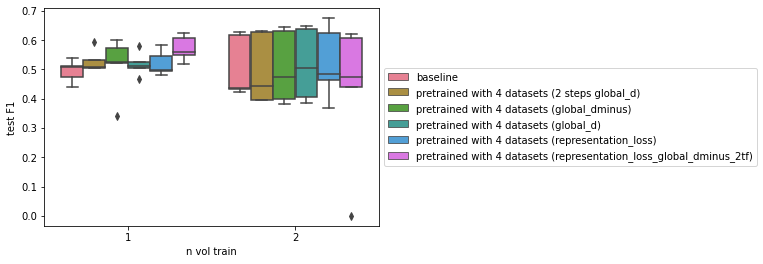

In [63]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

## Abide

### pretrain with Abide

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           64.0       crossentropy_loss baseline                                            0.298516   
                                         pretrained with Abide (global_d)                    0.328573   
                                         pretrained with Abide (global_dminus)               0.321728   
                                         pretrained with Abide (representation_loss_glob...  0.319439   
2           64.0       crossentropy_loss baseline                                            0.406749   
                                         pretrained with Abide (global_d)                    0.433340   
                                         pretrained with Abide (global_dminus)               0.434505   
                                         pretrained with Abide (representation_loss_glob...  0.433192   
5           64.0       crossentropy_loss baseline                                            0.463827   
                                         pretrained with Abide (global_d)                    0.472203   
                                         pretrained with Abide (global_dminus)               0.472513   
                                         pretrained with Abide (representation_loss_glob...  0.472449   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           64.0       crossentropy_loss baseline                                              0.086743   
                                         pretrained with Abide (global_d)                      0.053826   
                                         pretrained with Abide (global_dminus)                 0.082361   
                                         pretrained with Abide (representation_loss_glob...    0.086911   
2           64.0       crossentropy_loss baseline                                              0.039516   
                                         pretrained with Abide (global_d)                      0.009158   
                                         pretrained with Abide (global_dminus)                 0.015889   
                                         pretrained with Abide (representation_loss_glob...    0.011737   
5           64.0       crossentropy_loss baseline                                              0.009858   
                                         pretrained with Abide (global_d)                      0.009054   
                                         pretrained with Abide (global_dminus)                 0.008378   
                                         pretrained with Abide (representation_loss_glob...    0.010944   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           64.0       crossentropy_loss baseline                                            0.025040  
                                         pretrained with Abide (global_d)                    0.015538  
                                         pretrained with Abide (global_dminus)               0.023776  
                                         pretrained with Abide (representation_loss_glob...  0.025089  
2           64.0       crossentropy_loss baseline                                            0.011407  
                                         pretrained with Abide (global_d)                    0.002644  
                                         pretrained with Abide (global_dminus)               0.004587  
                                         pretrained with Abide (representation_loss_glob...  0.003388  
5           64.0       crossentropy_loss baseline                                      

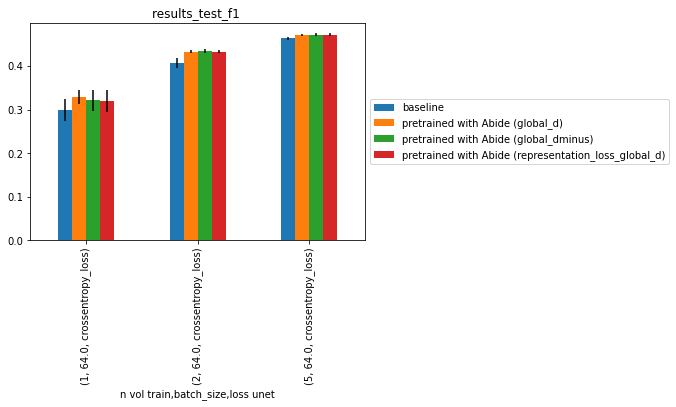

In [64]:
save_directory = './trained_models/Cardiac_only/Abide/'
pretrainings = ['baseline', 
                'pretrained with Abide (global_dminus)',
                'pretrained with Abide (global_d)',
                #'pretrained with Abide (representation_loss_global_dminus)',
                'pretrained with Abide (representation_loss_global_d)',
               ]
n_trains = [1, 2, 5]
losses =  ['crossentropy_loss']
lr = 0.001
batch_sizes = [64]     

runs = [ '0', '1', '2', '3']#, '4']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, '/Abide_results_f1', plot_loss = False)
results_test_f1

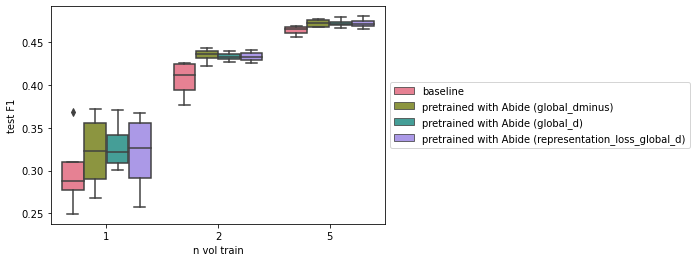

In [65]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

### Abide pretraining VS 4 datasets

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           64.0       crossentropy_loss baseline                                            0.297343   
                                         pretrained with 4 datasets (2 steps global_d)       0.346658   
                                         pretrained with 4 datasets (2 steps global_dminus)  0.324407   
                                         pretrained with 4 datasets (global_d)               0.311249   
                                         pretrained with 4 datasets (global_dminus)          0.353736   
                                         pretrained with 4 datasets (representation_loss...  0.333743   
                                         pretrained with 4 datasets (representation_loss...  0.361753   
                                         pretrained with Abide (global_d)                    0.329361   
                                         pretrained with Abide (global_dminus)               0.323151   
                                         pretrained with Abide (representation_loss_glob...  0.320980   
                                         pretrained with Abide (representation_loss_glob...  0.337548   
2           64.0       crossentropy_loss baseline                                            0.403109   
                                         pretrained with 4 datasets (2 steps global_d)       0.432719   
                                         pretrained with 4 datasets (2 steps global_dminus)  0.424424   
                                         pretrained with 4 datasets (global_d)               0.429694   
                                         pretrained with 4 datasets (global_dminus)          0.435513   
                                         pretrained with 4 datasets (representation_loss...  0.434632   
                                         pretrained with 4 datasets (representation_loss...  0.427855   
                                         pretrained with Abide (global_d)                    0.433758   
                                         pretrained with Abide (global_dminus)               0.433930   
                                         pretrained with Abide (representation_loss_glob...  0.432875   
                                         pretrained with Abide (representation_loss_glob...  0.431026   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           64.0       crossentropy_loss baseline                                              0.077727   
                                         pretrained with 4 datasets (2 steps global_d)         0.091919   
                                         pretrained with 4 datasets (2 steps global_dminus)    0.086401   
                                         pretrained with 4 datasets (global_d)                 0.119039   
                                         pretrained with 4 datasets (global_dminus)            0.082651   
                                         pretrained with 4 datasets (representation_loss...    0.072741   
                                         pretrained with 4 datasets (representation_loss...    0.045262   
                                         pretrained with Abide (global_d)                      0.048247   
                                         pretrained with Abide (global_dminus)                 0.073885   
                                         pretrained with Abide (representation_loss_glob...    0.077980   
                                         pretrained with Abide (representation_loss_glob...    0.073960   
2           64.0       crossentropy_loss baseline                                              0.038226   
                                         pretrained with 4 datasets (2 steps g

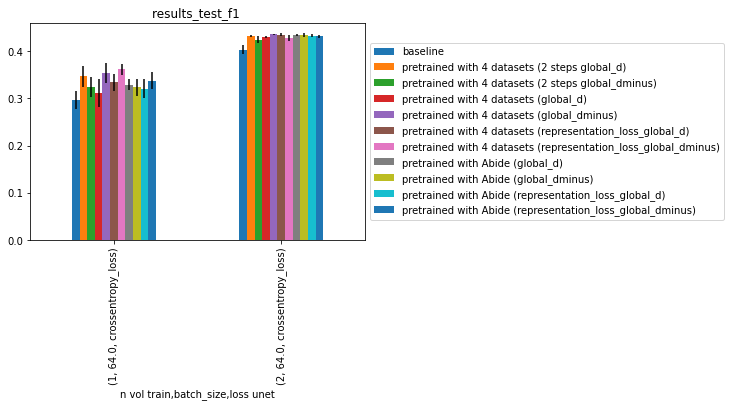

In [76]:
save_directory = './trained_models/Cardiac_only/Abide/'
pretrainings = ['baseline', 
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (2 steps global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
                'pretrained with Abide (global_d)',
                'pretrained with Abide (global_dminus)',
                'pretrained with Abide (representation_loss_global_d)',
                'pretrained with Abide (representation_loss_global_dminus)',
                
               ]
n_trains = [1,2]
losses =  ['crossentropy_loss']
lr = 0.001
batch_sizes = [64]     

runs = [ '0', '1', '2', '3', '4']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, '/Abide_results_f1', plot_loss = False)
results_test_f1

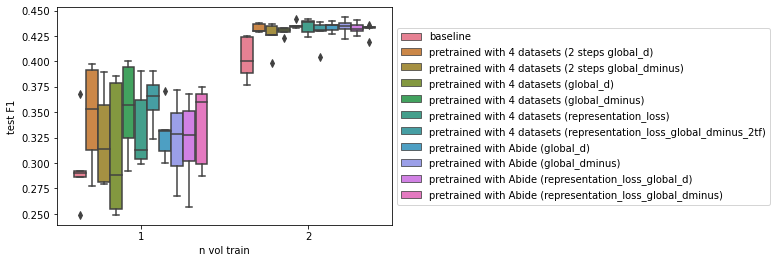

In [77]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)

### 4 datasets competition

/scratch_net/biwinura/celleaume/conda_envs/metastases/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


mean  \
n vol train batch_size loss unet         model                                                          
1           64.0       crossentropy_loss baseline                                            0.297343   
                                         pretrained with 4 datasets (2 steps global_d)       0.346658   
                                         pretrained with 4 datasets (2 steps global_dminus)  0.324407   
                                         pretrained with 4 datasets (global_d)               0.311249   
                                         pretrained with 4 datasets (global_dminus)          0.353736   
                                         pretrained with 4 datasets (representation_loss...  0.333743   
                                         pretrained with 4 datasets (representation_loss...  0.361753   
2           64.0       crossentropy_loss baseline                                            0.403109   
                                         pretrained with 4 datasets (2 steps global_d)       0.432719   
                                         pretrained with 4 datasets (2 steps global_dminus)  0.424424   
                                         pretrained with 4 datasets (global_d)               0.429694   
                                         pretrained with 4 datasets (global_dminus)          0.435513   
                                         pretrained with 4 datasets (representation_loss...  0.434632   
                                         pretrained with 4 datasets (representation_loss...  0.427855   

                                                                                             double_std  \
n vol train batch_size loss unet         model                                                            
1           64.0       crossentropy_loss baseline                                              0.077727   
                                         pretrained with 4 datasets (2 steps global_d)         0.091919   
                                         pretrained with 4 datasets (2 steps global_dminus)    0.086401   
                                         pretrained with 4 datasets (global_d)                 0.119039   
                                         pretrained with 4 datasets (global_dminus)            0.082651   
                                         pretrained with 4 datasets (representation_loss...    0.072741   
                                         pretrained with 4 datasets (representation_loss...    0.045262   
2           64.0       crossentropy_loss baseline                                              0.038226   
                                         pretrained with 4 datasets (2 steps global_d)         0.007405   
                                         pretrained with 4 datasets (2 steps global_dminus)    0.027062   
                                         pretrained with 4 datasets (global_d)                 0.006993   
                                         pretrained with 4 datasets (global_dminus)            0.006521   
                                         pretrained with 4 datasets (representation_loss...    0.013511   
                                         pretrained with 4 datasets (representation_loss...    0.024038   

                                                                                                  sem  
n vol train batch_size loss unet         model                                                         
1           64.0       crossentropy_loss baseline                                            0.019432  
                                         pretrained with 4 datasets (2 steps global_d)       0.022980  
                                         pretrained with 4 datasets (2 steps global_dminus)  0.021600  
                                         pretrained with 4 datasets (global_d)               0.029760  
                                         pretrained with 4 datasets (global_dmi

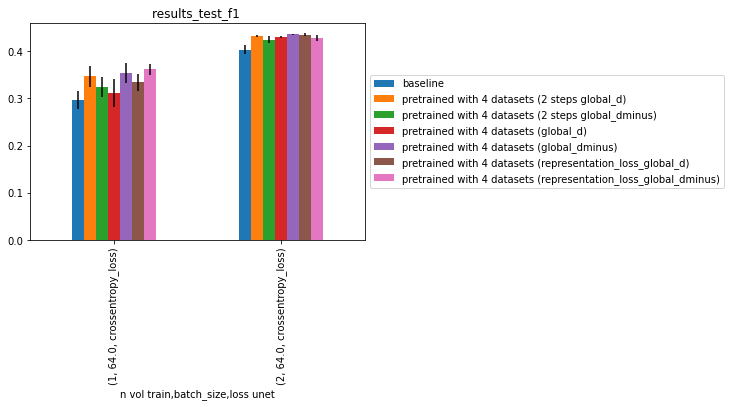

In [72]:
save_directory = './trained_models/Cardiac_only/Abide/'
pretrainings = ['baseline', 
                'pretrained with 4 datasets (2 steps global_d)',
                'pretrained with 4 datasets (2 steps global_dminus)',
                'pretrained with 4 datasets (global_dminus)',
                'pretrained with 4 datasets (global_d)',
                'pretrained with 4 datasets (representation_loss_global_d)',
                'pretrained with 4 datasets (representation_loss_global_dminus)',
               #'pretrained with 4 datasets (demeaned_representation_loss)',
                
               ]
n_trains = [1,2]
losses =  ['crossentropy_loss']
lr = 0.001
batch_sizes = [64]     

runs = [ '0', '1', '2', '3', '4']

results_test_f1, results = plot_results(save_directory, lr, pretrainings, n_trains, batch_sizes, losses, '/Abide_results_f1', plot_loss = False)
results_test_f1

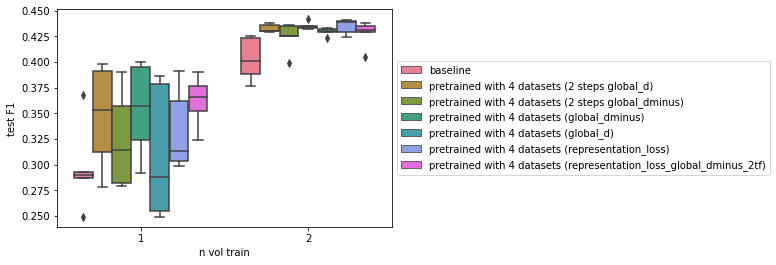

In [73]:
boxplot(save_directory, lr, pretrainings, n_trains, batch_sizes, losses,
                                        'ACDC_results_f1', plot_loss = False)